In [8]:
import shelve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from skopt import Optimizer, space
from sklearn.model_selection import KFold


In [2]:
#initialize dataframe, lines calculated with function to be explained later, xgs extracted from footystats sheets
season2021 =pd.read_csv("combinefd21.csv")
season2022 =pd.read_csv("combinefd22.csv")
season2023 =pd.read_csv("combinefd23.csv")
df = pd.concat([season2021, season2022, season2023]).reset_index(drop=True)
print(len(season2021))
print(len(season2022))
with shelve.open('inputs') as i:
    hls = i['hls']
    als = i['als']
df.insert(5, 'A_Line', als)
df.insert(5, 'H_Line', hls)
df.head(5)

7633
7821


,Div,Date,Time,HomeTeam,AwayTeam,H_Line,A_Line,FTHG,FTAG,HXG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,SC0,08/01/20,12:30,Aberdeen,Rangers,0.724756,1.770761,0,1,0.67,...,1.78,1.00,1.83,2.02,1.90,2.00,1.94,2.12,1.85,1.99
1,SC0,08/01/20,15:00,Dundee United,St Johnstone,1.094679,1.066453,1,1,1.49,...,1.52,0.00,1.93,1.93,1.91,1.99,2.00,1.99,1.92,1.93
2,SC0,08/01/20,15:00,Hibernian,Kilmarnock,1.511150,0.977880,2,1,1.24,...,1.76,-0.50,1.95,1.90,1.96,1.94,2.02,1.94,1.95,1.88
3,SC0,08/01/20,15:00,St Mirren,Livingston,0.945194,1.182613,1,0,0.94,...,1.53,0.25,1.85,2.00,1.88,2.01,1.90,2.08,1.83,2.01
4,SC0,08/02/20,16:30,Celtic,Hamilton,3.534317,0.420098,5,1,3.07,...,3.79,-3.00,1.98,1.88,2.01,1.88,2.04,1.92,1.96,1.87


In [4]:
def gather_data(decay): # decay factor used to compute weighted averages for recency
    # dictionaries to store stats for each team
    goals_for = {}
    goals_ag = {}
    xgoals_for = {}
    xgoals_ag = {}
    lines_for = {}
    lines_ag = {}

    # parameter names for the metrics
    param_names = ['goals', 'loglines']
    param_names += ['xgoals_lines_for', 'goals_lines_for', 
                'goals_xgoals_for','wxgoals_lines_for', 
                'wgoals_lines_for', 'wgoals_xgoals_for']
    param_names += ['xgoals_lines_ag', 'goals_lines_ag', 
                    'goals_xgoals_ag','wxgoals_lines_ag', 
                    'wgoals_lines_ag', 'wgoals_xgoals_ag']
    # minimum sample size for teams before betting on a match
    min_sample_size = 8

    # list to store training data rows
    training_rows = []

    # Iterate over each row in the DataFrame
    for index, row in df.iterrows(): 
        if index == 7633 or index == 7633+7821: #new seasons
            goals_for = {}
            goals_ag = {}
            xgoals_for = {}
            xgoals_ag = {}
            lines_for = {}
            lines_ag = {}
            
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        h_line = row['H_Line']
        a_line = row['A_Line']
        h_goals = row['FTHG']
        a_goals = row['FTAG']

        # Check if both teams have sufficient data for betting
        if home_team in goals_for and away_team in goals_for and len(goals_for[home_team]) >= min_sample_size and len(goals_for[away_team]) >= min_sample_size and sum(goals_for[home_team])>0 and sum(goals_for[away_team])>0 and sum(goals_ag[home_team])>0 and sum(goals_ag[away_team])>0:

            # Calculate various metrics for home and away teams
            h_xgoals_vs_lines_for, h_goals_vs_lines_for, h_goals_vs_xgoals_for, h_xgoals_vs_lines_ag, h_goals_vs_lines_ag, h_goals_vs_xgoals_ag = metrics(home_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag)
            a_xgoals_vs_lines_for, a_goals_vs_lines_for, a_goals_vs_xgoals_for, a_xgoals_vs_lines_ag, a_goals_vs_lines_ag, a_goals_vs_xgoals_ag = metrics(away_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag)
            weighted_h_xgoals_vs_lines_for, weighted_h_goals_vs_lines_for, weighted_h_goals_vs_xgoals_for, weighted_h_xgoals_vs_lines_ag, weighted_h_goals_vs_lines_ag, weighted_h_goals_vs_xgoals_ag = metrics(home_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag, True, decay)
            weighted_a_xgoals_vs_lines_for, weighted_a_goals_vs_lines_for, weighted_a_goals_vs_xgoals_for, weighted_a_xgoals_vs_lines_ag, weighted_a_goals_vs_lines_ag, weighted_a_goals_vs_xgoals_ag = metrics(away_team, goals_for, goals_ag, xgoals_for, xgoals_ag, lines_for, lines_ag, True, decay)

            # Apply the convert_metric function to each metric for home and away teams
            home_metrics = [h_xgoals_vs_lines_for, h_goals_vs_lines_for, h_goals_vs_xgoals_for, weighted_h_xgoals_vs_lines_for, weighted_h_goals_vs_lines_for, weighted_h_goals_vs_xgoals_for]
            home_metrics += [a_xgoals_vs_lines_ag, a_goals_vs_lines_ag, a_goals_vs_xgoals_ag, weighted_a_xgoals_vs_lines_ag, weighted_a_goals_vs_lines_ag, weighted_a_goals_vs_xgoals_ag]
            away_metrics = [a_xgoals_vs_lines_for, a_goals_vs_lines_for, a_goals_vs_xgoals_for, weighted_a_xgoals_vs_lines_for, weighted_a_goals_vs_lines_for, weighted_a_goals_vs_xgoals_for]
            away_metrics += [h_xgoals_vs_lines_ag, h_goals_vs_lines_ag, h_goals_vs_xgoals_ag, weighted_h_xgoals_vs_lines_ag, weighted_h_goals_vs_lines_ag, weighted_h_goals_vs_xgoals_ag]

            for i in range(12):
                home_metrics[i] = convert_metric(h_line, home_metrics[i])
                away_metrics[i] = convert_metric(a_line, away_metrics[i])

            # Create complete metrics Series for home and away teams
            complete_home_metrics = pd.Series([h_goals, np.log(h_line)]+home_metrics,index=param_names)
            complete_away_metrics = pd.Series([a_goals, np.log(a_line)]+away_metrics,index=param_names)

            # Append the metrics Series to the training_rows list
            training_rows.append(complete_home_metrics)
            training_rows.append(complete_away_metrics)

        # Update the dictionaries with new data for goals, expected goals, and lines
        h_xg = row['HXG']
        a_xg = row['AXG']
        if h_xg > 0 and abs(a_xg) > 0:
            goals_for[home_team] = goals_for.setdefault(home_team, [])+[h_goals]
            goals_for[away_team] = goals_for.setdefault(away_team, [])+[a_goals]
            goals_ag[home_team] = goals_ag.setdefault(home_team, [])+[a_goals]
            goals_ag[away_team] = goals_ag.setdefault(away_team, [])+[h_goals]
            xgoals_for[home_team] = xgoals_for.setdefault(home_team, [])+[h_xg]
            xgoals_for[away_team] = xgoals_for.setdefault(away_team, [])+[a_xg]
            xgoals_ag[home_team] = xgoals_ag.setdefault(home_team, [])+[a_xg]
            xgoals_ag[away_team] = xgoals_ag.setdefault(away_team, [])+[h_xg]
            lines_for[home_team] = lines_for.setdefault(home_team, [])+[h_line]
            lines_for[away_team] = lines_for.setdefault(away_team, [])+[a_line]
            lines_ag[home_team] = lines_ag.setdefault(home_team, [])+[a_line]
            lines_ag[away_team] = lines_ag.setdefault(away_team, [])+[h_line]
    return training_rows


In [4]:
# Initialize empty lists to store test decays and losses
test_decays = []
losses = []

# Define the compute_loss function with decay as the input
def compute_loss(decay):
    # Gather training data based on the decay value
    training_rows = gather_data(decay)
    
    # Concatenate the training data horizontally and transpose it
    data = pd.concat(training_rows, axis=1).T
    
    # Define the initial expression with the dependent variable 'goals' and the independent variable 'loglines'
    expr = 'goals ~ loglines'
    
    # Append the remaining column names to the expression
    for name in data.columns[2:]:
        expr += ' + ' + name
    
    # Create design matrices (y_train, X_train) using the formula expr and the data
    y_train, X_train = dmatrices(expr, data, return_type='dataframe')
    
    # Fit the model on the training data
    result = fit(X_train, y_train)
    
    # Calculate the parameters, considering values below a certain threshold as 0
    params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
    
    # Compute the loss based on the optimized parameters
    loss = result.fun
    
    # Print the decay and loss values
    print(decay, loss)
    
    # Append the decay and loss to the respective lists
    test_decays.append(decay)
    losses.append(loss)
    
    # Return the computed loss
    return loss

In [5]:
# Initialize the best_loss variable with infinity
best_loss = float('inf')

# Iterate over a range of values from 5 to 9 (inclusive)
for i in range(5, 10):
    # Compute the loss for the current decay value
    loss = compute_loss(i / 10)
    
    # Update the best_loss and best_decay variables if the current loss is smaller
    if loss < best_loss:
        best_loss = loss
        best_decay = i / 10

# Compute a seed value based on the best_decay
seed = int(best_decay * 100)

# Iterate over a range of values from seed-5 to seed+5
for i in range(seed - 5, seed + 5):
    # Compute the loss for the current decay value
    loss = compute_loss(i / 100)
    
    # Update the best_loss and best_decay variables if the current loss is smaller
    if loss < best_loss:
        best_loss = loss
        best_decay = i / 100

# Iterate over a range of values from 95 to 99
for i in range(95, 100):
    # Compute the loss for the current decay value
    loss = compute_loss(i / 100)
    
    # Update the best_loss and best_decay variables if the current loss is smaller
    if loss < best_loss:
        best_loss = loss
        best_decay = i / 100


0.5 1.4141180600978522
0.6 1.4141181409781394
0.7 1.414113172560841
0.8 1.4140996145470732
0.9 1.4140856238278416
0.85 1.414091756124039
0.86 1.4140903225484434
0.87 1.4140889629233007
0.88 1.4140877166995933
0.89 1.414086590383399
0.9 1.4140856238278416
0.91 1.414086015443017
0.92 1.4140846584301292
0.93 1.4140839025218725
0.94 1.4140843704729082
0.95 1.414083909419817
0.96 1.4141509543465434
0.97 1.4141515746672175
0.98 1.4141512137316379
0.99 1.4141518345339723


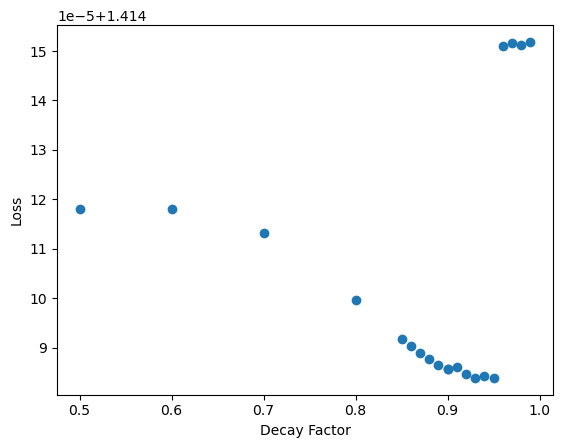

In [10]:
# Scatter plot of decay values vs. losses
plt.scatter(test_decays, losses)
plt.xlabel('Decay Factor')
plt.ylabel('Loss')
plt.show()

# Gather the training data based on the best decay value
training_rows = gather_data(best_decay)
data = pd.concat(training_rows, axis=1).T


In [11]:
expr = 'goals ~ loglines'
for name in data.columns[2:]:
    expr += ' + '+name

l1_wts = []
l2_wts = []
cv_losses = []

def cross_validate(l1_wt, l2_wt):
    # Create design matrix for all data
    y, X = dmatrices(expr, data, return_type='dataframe')
    
    kf = KFold(n_splits=10)  # Define the number of folds
    fold_losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit regularized model on the training data
        result = fit_regularized(X_train, y_train, l1_wt, l2_wt)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
        null = [0, 1] + [0] * (len(params) - 2)

        # Calculate the loss 
        fold_loss = objective_function(params, X_val, y_val) 
        fold_losses.append(fold_loss)
        
    # Store the l1_wt, l2_wt, and loss values for analysis
    l1_wts.append(l1_wt)
    l2_wts.append(l2_wt)
    average_loss = np.mean(fold_losses)
    cv_losses.append(average_loss)
    return average_loss

def objective(x):
    l1_wt, l2_wt = x
    return cross_validate(l1_wt, l2_wt)

sp = [space.Real(1e-10, .001, name='l1_wt', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt', prior='log-uniform')]
# Create an instance of Optimizer for Bayesian optimization and optimize
optimizer = Optimizer(sp, base_estimator='gp')
# Perform Bayesian optimization iterations
_ = optimizer.run(objective, 100)


C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


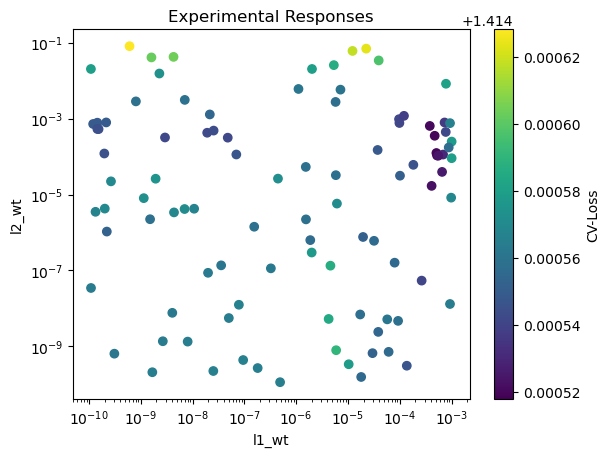

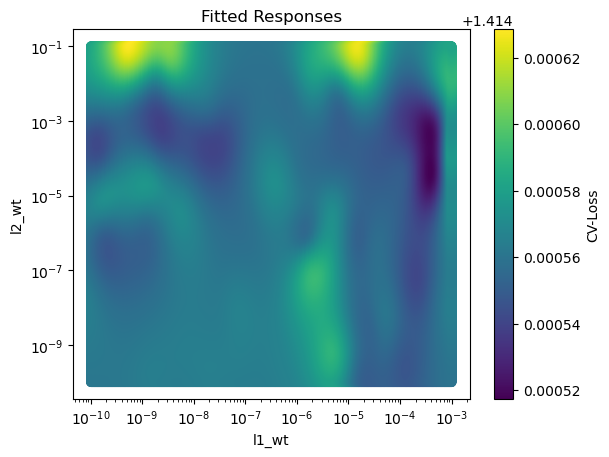

[0.954 0.63 ] [4.76430987e-04 4.67735141e-05] [1.4145173]


In [12]:
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(l1_wts, l2_wts, c=cv_losses, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Loss')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Experimental Responses')

# Display the plot
plt.show()

# Find optimal point
A=np.linspace(0.001, 1, 1000)
B=np.linspace(0.001, 1, 1000)
points = []
for a in A:
    for b in B:
        points.append(np.array([a, b]))
surrogate_model = optimizer.models[-1]
scores = np.array([surrogate_model.predict(point.reshape(1,-1)) for point in points])
f_l1_wts = []
f_l2_wts = []
f_cv_losses = []
for point, score in zip(points, scores):
    conv = point.copy()
    i = -10
    j1 = -3
    j2 = -1
    conv[0] = 10**(conv[0]*(j1-i)+i)
    conv[1] = 10**(conv[1]*(j2-i)+i)
    f_l1_wts.append(conv[0])
    f_l2_wts.append(conv[1])
    f_cv_losses.append(score)
    
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(f_l1_wts, f_l2_wts, c=f_cv_losses, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Loss')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Fitted Responses')

# Display the plot
plt.show()  

#find the best predicted point
argmin = np.argmin(scores)
point = points[argmin]
conv = point.copy()
i = -10
j1 = -3
j2 = -1
conv[0] = 10**(conv[0]*(j1-i)+i)
conv[1] = 10**(conv[1]*(j2-i)+i)
print(point, conv, scores[argmin])

In [13]:
#train model with tuned parameters on all data
param_names = ['intercept', 'loglines']
param_names += ['xgoals_lines_for', 'goals_lines_for', 
                'goals_xgoals_for','wxgoals_lines_for', 
                'wgoals_lines_for', 'wgoals_xgoals_for']
param_names += ['xgoals_lines_ag', 'goals_lines_ag', 
                'goals_xgoals_ag','wxgoals_lines_ag', 
                'wgoals_lines_ag', 'wgoals_xgoals_ag']
y, X = dmatrices(expr, data, return_type='dataframe')
best_l1_wt, best_l2_wt = conv
result = fit_regularized(X, y, best_l1_wt,best_l2_wt)
best_params = np.where(np.abs(result.x) <= 1e-5, 0, result.x) 
print(best_params)
for name, param in zip(param_names, best_params):
    print(name, param)

[-2.86666616e-02  1.04869302e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  7.59957423e-02  0.00000000e+00 -5.04157449e-02
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.85968633e-05
 -3.61753980e-02  0.00000000e+00]
intercept -0.028666661617796036
loglines 1.0486930151221563
xgoals_lines_for 0.0
goals_lines_for 0.0
goals_xgoals_for 0.0
wxgoals_lines_for 0.07599574232078428
wgoals_lines_for 0.0
wgoals_xgoals_for -0.0504157449355797
xgoals_lines_ag 0.0
goals_lines_ag 0.0
goals_xgoals_ag 0.0
wxgoals_lines_ag -4.859686326471936e-05
wgoals_lines_ag -0.036175398031313304
wgoals_xgoals_ag 0.0


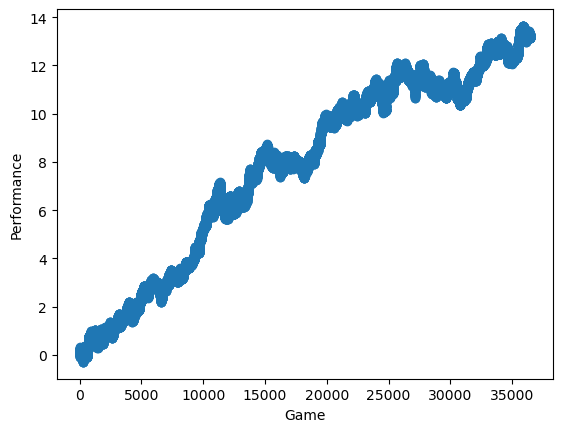

In [14]:
# Graph performance of the model to evaluate smoothness
null = [0,1]+[0]*(X.shape[1]-2)
alpha = -0.024
y_flat = y.values.flatten()
mu_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ best_params)))
null_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ null)))
game = list(range(len(mu_errors))) 
plt.scatter(game, np.cumsum(mu_errors-null_errors))
plt.xlabel('Game')
plt.ylabel('Performance')
plt.show()


In [15]:
# Idea 2: given the null, compute the distribution of losses between the null and alternative and return the z-score assuming
# that sum of all the difference is approximately normal
# Extract the 'loglines' values from the X DataFrame starting from 80% of the length
lines = np.exp(X['loglines'][round(len(X)*.8):])

# Function to create distributions and losses
def create_dists(lines):
    dists = []  # List to store probability distributions
    losses = []  # List to store losses

    # Iterate over lines and preds
    for line in lines:
        probs = []  # List to store individual probabilities
        l = []  # List to store individual losses
        i = 0
        cum = 0.0
        
        # Calculate probabilities and losses until cumulative probability exceeds 0.9999
        while cum < 0.9999:
            pmf = gpmf(i, -0.024, line)  # Calculate the probability mass function
            pmf_item = pmf.item()  # Extract the value of the probability mass function
            cum += pmf_item  # Update the cumulative probability
            probs.append(pmf_item)  # Append the probability to the list of probabilities
            l.append(-np.log(pmf_item))  # Append the loss to the list of losses
            i += 1

        dists.append(probs + [1.0 - cum])  # Append the probabilities with the remaining probability to the dists list
        losses.append(l + [-np.log(1.0 - cum)])  # Append the losses with the final loss to the losses list

    return dists, losses

# Call the create_dists function to compute dists and losses
dists, losses = create_dists(lines)


In [16]:

expr = 'goals ~ loglines'
# Iterate over the columns of the data DataFrame starting from the third column
for name in data.columns[2:]:
    expr += ' + '+name  # Append column names to the expression for linear regression

l1_wts = []  # List to store l1_wt values
l2_wts = []  # List to store l2_wt values
cv_scores = []  # List to store cross-validation scores

# Function for cross-validation
def cross_validate(l1_wt, l2_wt):   
    # Create design matrix for all data
    y, X = dmatrices(expr, data, return_type='dataframe')

    kf = KFold(n_splits=10)  # Define the number of folds
    fold_scores = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Fit a regularized linear regression model
        result = fit_regularized(X_train, y_train, l1_wt, l2_wt)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)  # Threshold parameters close to zero
        null = [0, 1] + [0] * (len(params) - 2)  # Null model parameters

        preds = np.exp(X_test @ params)  # Generate predictions using the fitted model

        rvs = []  # List to store random variables
        for pred, loss, dist in zip(preds, losses, dists):
            loss_diff = []
            # Calculate the difference between predicted and actual losses for each observation
            for i in range(len(loss)):
                pred_pmf = gpmf(i, -.024, pred)
                loss_diff.append(-np.log(pred_pmf) - loss[i])
            rv = rv_discrete(values=(loss_diff, dist))  # Create a random variable with the loss differences and distribution
            rvs.append(rv)

        mean = var = 0
        for rv in rvs:
            mean += rv.mean()  # Compute the mean of the random variables
            var += rv.var()  # Compute the variance of the random variables

        std = np.sqrt(var)  # Calculate the standard deviation
        model_loss = objective_function(params, X_test, y_test)  # Calculate the loss of the model predictions
        null_loss = objective_function([0, 1] + [0] * (len(params) - 2), X_test, y_test)  # Calculate the loss of the null model
        x = (model_loss - null_loss) * len(X_test)  # Compute the difference in losses scaled by the number of observations
        
        score = (x - mean) / std  # Compute the cross-validation score
        fold_scores.append(score)
    l1_wts.append(l1_wt)
    l2_wts.append(l2_wt)
    average_score = np.mean(fold_scores)
    cv_scores.append(average_score)
    return average_score


def objective(x):
    l1_wt, l2_wt = x
    return cross_validate(l1_wt, l2_wt)

sp = [space.Real(1e-10, .001, name='l1_wt', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt', prior='log-uniform')]
# Create an instance of Optimizer for Bayesian optimization and optimize
optimizer = Optimizer(sp, base_estimator='gp')
# Perform Bayesian optimization iterations
_ = optimizer.run(objective, 100)


C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\Bryant Ndongmo\AppData\Roaming\Python\Python39\site-packages\skopt\optimizer\optimizer.py:449: 

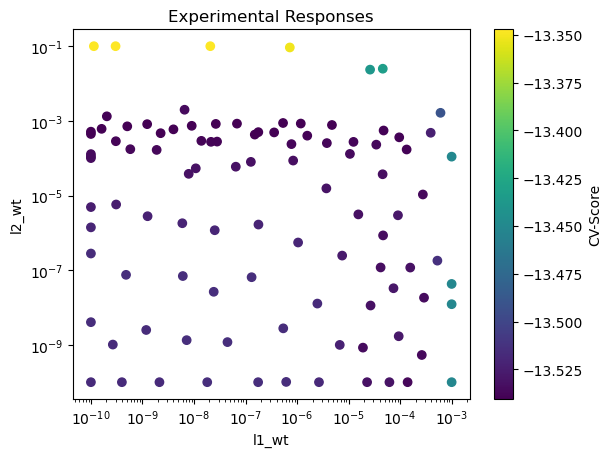

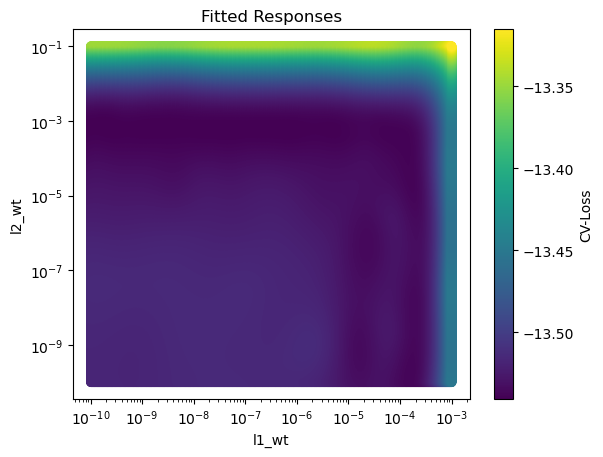

[0.553 0.755] [7.43019138e-07 6.23734835e-04] [-13.54079798]


In [17]:
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(l1_wts, l2_wts, c=cv_scores, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Score')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Experimental Responses')

# Display the plot
plt.show()

# Find optimal point
A=np.linspace(0.001, 1, 1000)
B=np.linspace(0.001, 1, 1000)
points = []
for a in A:
    for b in B:
        points.append(np.array([a, b]))
surrogate_model = optimizer.models[-1]
scores = np.array([surrogate_model.predict(point.reshape(1,-1)) for point in points])
f_l1_wts = []
f_l2_wts = []
f_cv_losses = []
for point, score in zip(points, scores):
    conv = point.copy()
    i = -10
    j1 = -3
    j2 = -1
    conv[0] = 10**(conv[0]*(j1-i)+i)
    conv[1] = 10**(conv[1]*(j2-i)+i)
    f_l1_wts.append(conv[0])
    f_l2_wts.append(conv[1])
    f_cv_losses.append(score)
    
# Create a scatter plot
plt.xscale('log')
plt.yscale('log')
plt.scatter(f_l1_wts, f_l2_wts, c=f_cv_losses, cmap='viridis')

# Add color bar legend
cbar = plt.colorbar()
cbar.set_label('CV-Loss')

# Set labels for x and y axes
plt.xlabel('l1_wt')
plt.ylabel('l2_wt')

# Set a title for the plot
plt.title('Fitted Responses')

# Display the plot
plt.show()  

argmin = np.argmin(scores)
point = points[argmin]
conv = point.copy()
i = -10
j1 = -3
j2 = -1
conv[0] = 10**(conv[0]*(j1-i)+i)
conv[1] = 10**(conv[1]*(j2-i)+i)
print(point, conv, scores[argmin])

[7.43019138e-07 6.23734835e-04]
[-0.03505486  1.06103675 -0.05271121 -0.04186586  0.08348679  0.17451465
  0.02760812 -0.11458135  0.04847683  0.01927236  0.01274057 -0.03713901
 -0.08185566  0.01015881]


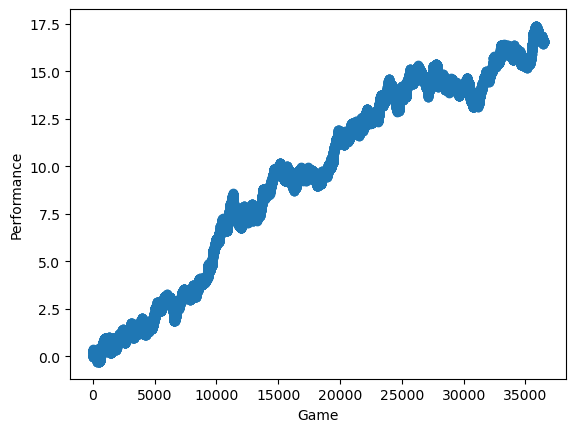

In [19]:
#train model with tuned parameters on all data
y, X = dmatrices(expr, data, return_type='dataframe')
best_l1_wt2, best_l2_wt2 =conv
print(conv)
result2 = fit_regularized(X, y, best_l1_wt2,best_l2_wt2)
best_params2 = np.where(np.abs(result2.x) <= 1e-5, 0, result2.x) 
print(best_params2)

#graph performance
null = [0,1]+[0]*(X.shape[1]-2)
alpha = -0.024
y_flat = y.values.flatten()
mu_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ best_params2)))
null_errors = np.log(gpmf(y_flat, alpha, np.exp(X @ null)))
game = list(range(len(mu_errors))) 
plt.scatter(game, np.cumsum(mu_errors-null_errors))
plt.xlabel('Game')
plt.ylabel('Performance')
plt.show()

In [15]:

#demonstration of function that computes the home and away lines based on pinnacle ml, handicap, and o/u 2.5 odds (all have been shelved already)
for i in range(20):
    row = df.loc[i]
    ah = row['AHCh']
    o, u = extract_probabilities((row["PC>2.5"], row["PC<2.5"]))
    if np.isnan(o):
        o, u = extract_probabilities((row["AvgC>2.5"], row["AvgC<2.5"]))
    h, d, a = extract_probabilities((row['PSCH'], row['PSCD'], row['PSCA']))
    if np.isnan(h):
        h, d, a =  extract_probabilities((row['AvgCH'], row['AvgCD'], row['AvgCA']))
    hc, ac = extract_probabilities((row["PCAHH"], row["PCAHA"]))
    if np.isnan(hc):
        hc, ac = extract_probabilities((row["AvgCAHH"], row["AvgCAHA"]))

    params = get_params(h, d, a, o, u, hc, ac, ah, 2.4).x
    theta1, theta2 = params
    theta3 = get_theta3(.0048, theta1, theta2, -.024) 
    hl = theta1/(1+.024)+theta3/(1+.024)
    al = theta2/(1+.024)+theta3/(1+.024)
    print(h, d, a, o, u, hl, al)


NameError: name 'base' is not defined

In [ ]:
#extracting xgs from footystats sheet
latest = pd.read_csv("Latest_Results.csv") #sheet from footballdata
fs = pd.read_csv("combinefs23.csv") #footystats
fs = fs.query("status != 'suspended' & timestamp >= 1684513800").reset_index() # make sure timestamp starts from where to start getting stats
with shelve.open('namemap') as s:
    fdtofs, fstofd = s['1']
    
fdrows = []
fsrows = []
hxgs = []
axgs = []

for i in range(len(latest)):
    fdrows.append(latest.loc[i])
for i in range(len(fs)):
    fsrows.append(fs.loc[i])

for row in fdrows:
    found = False   
    for i in range(len(fsrows)):   
        if fdtofs[row['HomeTeam']] == fsrows[i]['home_team_name']:
            hxgs.append(fsrows[i]['team_a_xg'])
            axgs.append(fsrows[i]['team_b_xg'])
            fsrows.pop(i)
            found = True
            break
    if not found:
        print(row)
  

In [143]:
#neural network early stopping idea, no luck
param_names = ['intercept', 'loglines']
param_names += ['xgoals_lines_for', 'goals_lines_for', 
                'goals_xgoals_for','wxgoals_lines_for', 
                'wgoals_lines_for', 'wgoals_xgoals_for']
param_names += ['xgoals_lines_ag', 'goals_lines_ag', 
                'goals_xgoals_ag','wxgoals_lines_ag', 
                'wgoals_lines_ag', 'wgoals_xgoals_ag']
expr = 'goals ~ loglines'
    
# Append the remaining column names to the expression
for name in data.columns[2:]:
    expr += ' + ' + name
y, X = dmatrices(expr, data, return_type='dataframe')
hidden_units = 4
# Existing tensors for weight initialization
def custom_initializer(shape, dtype=tf.float32):
    # Define your desired weight values
    arr = np.array([[0.0, 1.0] + [0.0] * 12]).T
    arr = np.tile(arr, (1, hidden_units))
    weights = tf.constant(arr, dtype=dtype)
   
    return weights

def custom_initializer2(shape, dtype=tf.float32):
    # Define your desired weight values
    arr =  np.linspace(-1,1,hidden_units).T.reshape(-1,1)
    weights = tf.constant(arr, dtype=dtype)
   
    return weights


def loss_fn(y_true, y_pred):
    def gpmf(x, alpha, lamb):
        lamb *= (1 - alpha)
        p = (lamb * tf.math.pow(lamb + alpha * x, x - 1) * tf.exp(-lamb - alpha * x)) / tf.exp(tf.math.lgamma(x + 1))
        
        p = tf.where(p <= 0, 1e-8, p)
        p = tf.where(p > 1, 1.0, p)
        p = tf.where(tf.math.is_nan(p), 1e-8, p)
        return p
    loss = tf.math.log(gpmf(y_true, -.024, y_pred))
    return -loss

models = []
for _ in range(10):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(hidden_units,use_bias=False,kernel_initializer=custom_initializer,activation='relu'),
        tf.keras.layers.Dense(1,use_bias=False,kernel_initializer=custom_initializer2,activation='exponential')
    ])
    
    # Compile model
    model.compile(optimizer='adam', loss=loss_fn)
    models.append(model)

X = tf.convert_to_tensor(X)
y = tf.convert_to_tensor(y)


# Perform k-fold cross-validation
kf = KFold(n_splits=10)
epochs_since_last_imp = 0
best_loss = float('inf')

patience = 2
epoch = 0
step = 100
while epochs_since_last_imp < patience:
    nn_losses = [] 
    for split_index, (train_index, val_index) in enumerate(kf.split(X)):
        train_indices = train_index.tolist()
        val_indices = val_index.tolist()
        X_train, X_val = tf.gather(X, train_index), tf.gather(X, val_index)
        y_train, y_val = tf.gather(y, train_index), tf.gather(y, val_index)

        # Fit model 10 times and evaluate the model on the validation set
        model = models[split_index]
        model.fit(X_train, y_train, epochs=step, batch_size=len(X_train), verbose=False)
        loss = model.evaluate(X_val, y_val, verbose=False)
        nn_losses.append(loss)

    # Compute the average loss across all folds
    average_loss = np.mean(nn_losses)
    print("Average Loss:", average_loss, (epoch+1)*step)
    if average_loss < best_loss:
        epochs_since_last_imp = 0
        best_loss = average_loss
        best_e = (epoch+1)*step
    else:
        epochs_since_last_imp += 1
    epoch += 1

average_loss = best_loss
print("Best Average Loss:", average_loss, best_e)

Average Loss: 1.4145888805389404 100
Average Loss: 1.4145851969718932 200
Average Loss: 1.414573872089386 300
Average Loss: 1.4145639538764954 400
Average Loss: 1.41455796957016 500
Average Loss: 1.4145557522773742 600
Average Loss: 1.4145562410354615 700
Average Loss: 1.4145577192306518 800
Best Average Loss: 1.4145557522773742 500


In [157]:
#go back to first model, error analysis
best_l1_wt, best_l2_wt = 4.76430987e-04,4.67735141e-05
result = fit_regularized(X.numpy(), pd.DataFrame(y), best_l1_wt, best_l2_wt)
best_params = np.where(np.abs(result.x) <= 1e-5, 0, result.x) 
print(best_params)

[-0.02867062  1.04870387  0.          0.          0.          0.07605022
  0.         -0.0503896   0.          0.          0.          0.
 -0.03621236  0.        ]


In [275]:
#nothing going here either
preds = tf.convert_to_tensor(np.exp(X.numpy()@best_params).reshape(-1,1))
def loss_fn(y_true, y_pred):

    def gpmf(x, alpha, lamb):
        lamb *= (1 - alpha)
        p = (lamb * tf.math.pow(lamb + alpha * x, x - 1) * tf.exp(-lamb - alpha * x)) / tf.exp(tf.math.lgamma(x + 1))
        
        p = tf.where(p <= 0, 1e-8, p)
        p = tf.where(p > 1, 1.0, p)
        p = tf.where(tf.math.is_nan(p), 1e-8, p)
        return p
    loss = tf.math.log(gpmf(y, -.024, preds+tf.cast(y_pred, dtype=tf.float64)))
    return -loss

# kernel_initializer=tf.zeros_initializer()
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1))

#print(tf.reduce_mean(tf.math.log(gpmf(y, -.024, preds))))
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer='adam', loss=loss_fn)
model.fit(X, y, epochs=1000, batch_size=len(X))


Epoch 1/1000
1/1 [==============================] - 0s 147ms/step - loss: 1.4765
Epoch 2/1000
1/1 [==============================] - 0s 120ms/step - loss: 1.4720
Epoch 3/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4722
Epoch 4/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.4727
Epoch 5/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4719
Epoch 6/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.4710
Epoch 7/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4701
Epoch 8/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4707
Epoch 9/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.4672
Epoch 10/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.4682
Epoch 11/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4657
Epoch 12/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.4646
Epoch 13/1000
1/1 [======

1/1 [==============================] - 0s 132ms/step - loss: 1.4281
Epoch 102/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4262
Epoch 103/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.4274
Epoch 104/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4269
Epoch 105/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.4261
Epoch 106/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4276
Epoch 107/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4262
Epoch 108/1000
1/1 [==============================] - 0s 148ms/step - loss: 1.4259
Epoch 109/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.4258
Epoch 110/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.4251
Epoch 111/1000
1/1 [==============================] - 0s 116ms/step - loss: 1.4259
Epoch 112/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.4260
Epoch 113/1000
1/1 

1/1 [==============================] - 0s 144ms/step - loss: 1.4194
Epoch 200/1000
1/1 [==============================] - 0s 159ms/step - loss: 1.4192
Epoch 201/1000
1/1 [==============================] - 0s 147ms/step - loss: 1.4183
Epoch 202/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4187
Epoch 203/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4188
Epoch 204/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4191
Epoch 205/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4183
Epoch 206/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.4188
Epoch 207/1000
1/1 [==============================] - 0s 128ms/step - loss: 1.4187
Epoch 208/1000
1/1 [==============================] - 0s 108ms/step - loss: 1.4192
Epoch 209/1000
1/1 [==============================] - 0s 123ms/step - loss: 1.4183
Epoch 210/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4185
Epoch 211/1000
1/1 

1/1 [==============================] - 0s 143ms/step - loss: 1.4157
Epoch 298/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4156
Epoch 299/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.4164
Epoch 300/1000
1/1 [==============================] - 0s 148ms/step - loss: 1.4159
Epoch 301/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4156
Epoch 302/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.4161
Epoch 303/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4159
Epoch 304/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.4163
Epoch 305/1000
1/1 [==============================] - 0s 150ms/step - loss: 1.4164
Epoch 306/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4157
Epoch 307/1000
1/1 [==============================] - 0s 124ms/step - loss: 1.4164
Epoch 308/1000
1/1 [==============================] - 0s 141ms/step - loss: 1.4159
Epoch 309/1000
1/1 

1/1 [==============================] - 0s 135ms/step - loss: 1.4152
Epoch 396/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4155
Epoch 397/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4151
Epoch 398/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4146
Epoch 399/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4155
Epoch 400/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.4152
Epoch 401/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4156
Epoch 402/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.4150
Epoch 403/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.4151
Epoch 404/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.4152
Epoch 405/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.4156
Epoch 406/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.4153
Epoch 407/1000
1/1 

1/1 [==============================] - 0s 132ms/step - loss: 1.4147
Epoch 494/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.4149
Epoch 495/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.4152
Epoch 496/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4148
Epoch 497/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4148
Epoch 498/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4148
Epoch 499/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4149
Epoch 500/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4148
Epoch 501/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.4150
Epoch 502/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4148
Epoch 503/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4151
Epoch 504/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4147
Epoch 505/1000
1/1 

1/1 [==============================] - 0s 135ms/step - loss: 1.4148
Epoch 592/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4147
Epoch 593/1000
1/1 [==============================] - 0s 134ms/step - loss: 1.4149
Epoch 594/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4151
Epoch 595/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4148
Epoch 596/1000
1/1 [==============================] - 0s 125ms/step - loss: 1.4146
Epoch 597/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.4149
Epoch 598/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4149
Epoch 599/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.4151
Epoch 600/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4147
Epoch 601/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4145
Epoch 602/1000
1/1 [==============================] - 0s 138ms/step - loss: 1.4147
Epoch 603/1000
1/1 

1/1 [==============================] - 0s 133ms/step - loss: 1.4145
Epoch 690/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.4147
Epoch 691/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.4145
Epoch 692/1000
1/1 [==============================] - 0s 133ms/step - loss: 1.4146
Epoch 693/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4146
Epoch 694/1000
1/1 [==============================] - 0s 144ms/step - loss: 1.4147
Epoch 695/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4148
Epoch 696/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4145
Epoch 697/1000
1/1 [==============================] - 0s 146ms/step - loss: 1.4146
Epoch 698/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.4144
Epoch 699/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.4146
Epoch 700/1000
1/1 [==============================] - 0s 140ms/step - loss: 1.4148
Epoch 701/1000
1/1 

1/1 [==============================] - 0s 132ms/step - loss: 1.4147
Epoch 788/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4145
Epoch 789/1000
1/1 [==============================] - 0s 137ms/step - loss: 1.4144
Epoch 790/1000
1/1 [==============================] - 0s 143ms/step - loss: 1.4146
Epoch 791/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4144
Epoch 792/1000
1/1 [==============================] - 0s 131ms/step - loss: 1.4146
Epoch 793/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.4146
Epoch 794/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4144
Epoch 795/1000
1/1 [==============================] - 0s 132ms/step - loss: 1.4144
Epoch 796/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4146
Epoch 797/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4145
Epoch 798/1000
1/1 [==============================] - 0s 139ms/step - loss: 1.4147
Epoch 799/1000
1/1 

1/1 [==============================] - 0s 134ms/step - loss: 1.4146
Epoch 886/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4145
Epoch 887/1000
1/1 [==============================] - 0s 135ms/step - loss: 1.4146
Epoch 888/1000
1/1 [==============================] - 0s 121ms/step - loss: 1.4144
Epoch 889/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4146
Epoch 890/1000
1/1 [==============================] - 0s 130ms/step - loss: 1.4144
Epoch 891/1000
1/1 [==============================] - 0s 127ms/step - loss: 1.4146
Epoch 892/1000
1/1 [==============================] - 0s 145ms/step - loss: 1.4145
Epoch 893/1000
1/1 [==============================] - 0s 147ms/step - loss: 1.4146
Epoch 894/1000
1/1 [==============================] - 0s 153ms/step - loss: 1.4146
Epoch 895/1000
1/1 [==============================] - 0s 125ms/step - loss: 1.4145
Epoch 896/1000
1/1 [==============================] - 0s 129ms/step - loss: 1.4148
Epoch 897/1000
1/1 

1/1 [==============================] - 0s 163ms/step - loss: 1.4146
Epoch 984/1000
1/1 [==============================] - 0s 136ms/step - loss: 1.4144
Epoch 985/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.4143
Epoch 986/1000
1/1 [==============================] - 0s 122ms/step - loss: 1.4146
Epoch 987/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.4143
Epoch 988/1000
1/1 [==============================] - 0s 118ms/step - loss: 1.4143
Epoch 989/1000
1/1 [==============================] - 0s 117ms/step - loss: 1.4146
Epoch 990/1000
1/1 [==============================] - 0s 119ms/step - loss: 1.4144
Epoch 991/1000
1/1 [==============================] - 0s 142ms/step - loss: 1.4144
Epoch 992/1000
1/1 [==============================] - 0s 112ms/step - loss: 1.4146
Epoch 993/1000
1/1 [==============================] - 0s 107ms/step - loss: 1.4144
Epoch 994/1000
1/1 [==============================] - 0s 113ms/step - loss: 1.4146
Epoch 995/1000
1/1 

In [276]:
predictions = model.predict(X)
print(predictions)
for layer_weights in model.get_weights():
    print(layer_weights)

1140/1140 [==============================] - 2s 2ms/step
[[ 0.02156052]
 [ 0.06048067]
 [ 0.01236401]
 ...
 [-0.01860412]
 [-0.02849946]
 [-0.01387512]]
[[ 0.23389274  0.04564025]
 [ 0.00081718 -0.02441826]
 [-0.1949747   0.40140492]
 [ 0.27803344 -0.24986081]
 [-0.22012858 -0.05928143]
 [-0.52295405  0.5877417 ]
 [ 0.23150824 -0.43013522]
 [-0.01262358  0.39384413]
 [ 0.10693099 -0.5687619 ]
 [ 0.24322198  0.46909773]
 [ 0.093725   -0.41980615]
 [ 0.10101224 -0.31611347]
 [ 0.04747916 -0.04710377]
 [-0.27357063 -0.03328126]]
[-0.16761416  0.21049622]
[[0.5713654 ]
 [0.31145337]]
[-0.1258067]


In [335]:
# new idea, replace log lines with log predictions as another "layer"
import time 
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=pd.core.common.SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

def cross_validate(l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2):
    kf = KFold(n_splits=10)  # Define the number of folds
    y, X = dmatrices(expr, data, return_type='dataframe')
    fold_losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit regularized model on the training data
        result = fit_regularized(X_train, y_train, l1_wt_1, l2_wt_1)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
        train_preds = np.exp(X_train@params)
        train_log_preds = np.log(train_preds)
        val_preds = np.exp(X_val@params)
        val_log_preds = np.log(val_preds)
        X_train.loc[:, 'loglines'] = train_log_preds
        X_val.loc[:, 'loglines'] = val_log_preds
        result = fit_regularized(X_train, y_train, l1_wt_2, l2_wt_2)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
        
        # Calculate the loss 
        y_pred = np.array(np.exp(X_val@params)).reshape(-1,1)
        mu_errors = np.log(gpmf(y_val, -.024, y_pred))
        fold_loss = -np.mean(mu_errors)
        fold_losses.append(fold_loss)
        
    average_loss = np.mean(fold_losses)
    return average_loss

sp = [space.Real(1e-10, .001, name='l1_wt_1', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt_1', prior='log-uniform')]
sp += [space.Real(1e-10, .001, name='l1_wt_2', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt_2', prior='log-uniform')]
# Create an instance of Optimizer for Bayesian optimization and optimize
#optimizer = Optimizer(sp, base_estimator='gp')

def objective(x):
    l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2 = x
    return cross_validate(l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2)




KeyboardInterrupt: 

In [346]:
# Set the desired timeout in seconds
timeout_seconds = 3600 * 5  # 5 hours

# Perform Bayesian optimization iterations with timeout
start_time = time.time()
elapsed_time = 0
while elapsed_time < timeout_seconds:
    optimizer.run(objective, n_iter=1)  # Run a single iteration
    elapsed_time = time.time() - start_time
    


In [347]:
# Retrieve the best result
Xi = optimizer.Xi
yi = optimizer.yi
argmin = np.argmin(yi)
best_params = Xi[argmin]
best_loss = yi[argmin]

print("Best Parameters:", best_params)
print("Best Loss:", best_loss)

Best Parameters: [0.001, 4.417905300370236e-10, 0.00048214163633196374, 1e-10]
Best Loss: 1.414517855526331


In [350]:
def cross_validate(l1_wt, l2_wt):
    # Create design matrix for all data
    y, X = dmatrices(expr, data, return_type='dataframe')
    
    kf = KFold(n_splits=10)  # Define the number of folds
    fold_losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        # Fit regularized model on the training data
        result = fit_regularized(X_train, y_train, l1_wt, l2_wt)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
        null = [0, 1] + [0] * (len(params) - 2)

        # Calculate the loss 
        fold_loss = objective_function(params, X_val, y_val) 
        fold_losses.append(fold_loss)
        
    # Store the l1_wt, l2_wt, and loss values for analysis
    l1_wts.append(l1_wt)
    l2_wts.append(l2_wt)
    average_loss = np.mean(fold_losses)
    cv_losses.append(average_loss)
    return average_loss


1.4146699896205048


In [486]:
def objective_function_with_alpha(params, X, y, method='ll', l1_wt_1=0, l2_wt_1=0, l1_wt_2=0, l2_wt_2=0):
    beta1 = params[:14]
    beta2 = params[14:]
    preds = np.exp(X @ beta1).reshape(-1,1)
    alpha = np.tanh(X @ beta2).reshape(-1,1)*.1-.024
    loss = -np.mean(np.log(gpmf(y, alpha, preds)))
    if method == 'll': 
        return loss
    if method == 'll_regularized':
        adj1 = abs(beta1[1]-1)-abs(beta1[1])
        adj2 = (beta1[1]-1)**2-beta1[1]**2
        loss += l1_wt_1*(np.linalg.norm(beta1, ord=1)+adj1)+l2_wt_1*(np.linalg.norm(beta1, ord=2)**2+adj2)
        loss += l1_wt_2*np.linalg.norm(beta2, ord=1)+l2_wt_1*np.linalg.norm(beta2, ord=2)**2
        return loss
    
def fit_with_alpha(X_train, y_train):
    null = [0,1]+[0]*(X_train.shape[1]-2)+[0]*(X_train.shape[1])
    return minimize(objective_function_with_alpha, null, args=(X_train, y_train), method='bfgs', options={'disp':False})
    
def fit_regularized_with_alpha(X_train, y_train, l1_wt_1=0, l2_wt_1=0, l1_wt_2=0, l2_wt_2=0):
    null = [0,1]+[0]*(X_train.shape[1]-2)+[0]*(X_train.shape[1])
    return minimize(objective_function_with_alpha, null, args=(X_train, y_train,'ll_regularized', l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2), method='bfgs', options={'disp':False})

def cross_validate(l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2):  
    kf = KFold(n_splits=10)  # Define the number of folds
    fold_losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Fit regularized model on the training data
        result = fit_regularized_with_alpha(X_train, y_train, l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
 
        # Calculate the loss 
        fold_loss = objective_function_with_alpha(params, X_val, y_val) 
        fold_losses.append(fold_loss)
        
    average_loss = np.mean(fold_losses)
    return average_loss

def objective(x):
    l1_wt_1, l2_wt_1, l1_wt_2, l1_wt_2 = x
    return cross_validate(l1_wt_1, l2_wt_1, l1_wt_2, l1_wt_2)


sp = [space.Real(1e-10, .001, name='l1_wt_1', prior='log-uniform'), space.Real(1e-10, .1, name='l2_wt_1', prior='log-uniform')]
sp += [space.Real(1e-10, .001, name='l1_wt_2', prior='log-uniform'), space.Real(1e-10, 1, name='l2_wt_2', prior='log-uniform')]

# Create an instance of Optimizer for Bayesian optimization and optimize
optimizer = Optimizer(sp, base_estimator='gp')

# Set the desired timeout in seconds
timeout_seconds = 3600 * 10 # 10 hours

# Perform Bayesian optimization iterations with timeout
start_time = time.time()
elapsed_time = 0
while elapsed_time < timeout_seconds:
    optimizer.run(objective, n_iter=1)  # Run a single iteration
    elapsed_time = time.time() - start_time
    
# Retrieve the best result
Xi = optimizer.Xi
yi = optimizer.yi
argmin = np.argmin(yi)
best_params = Xi[argmin]
best_loss = yi[argmin]

print("Best Parameters:", best_params)
print("Best Loss:", best_loss)


Best Parameters: [0.0003668914238456959, 9.331179242759551e-05, 6.195958718189732e-07, 5.43347571883688e-08]
Best Loss: 1.414466153062929


In [824]:
"""
alphas = np.tanh(X@p)*.1
print(np.mean(alphas-.024))
print(alphas-.024, fun)
for name, p_ in zip(param_names, p):
    print(name, p_)
print(X[np.argmax(alphas)])
print(min(alphas))
"""
def objective_function_with_alpha(params, X, y, method='ll', l1_wt_1=0, l2_wt_1=0, l1_wt_2=0, l2_wt_2=0):
    beta1 = params[:14].reshape(-1,1)
    beta2 = params[14:].reshape(-1,1)
    preds = np.exp(X @ beta1)
    tb = np.tanh(X @ beta2)
    alpha = tb*.1-.024
    p = gpmf(y, alpha, preds)
    loss = -np.mean(np.log(p))
    
    #jac
    pa = preds * (1-alpha)
    dloss_dp = -1/p
    dp_dpa = np.exp(-preds - alpha * y) * (preds + alpha * y)**(y - 1) + preds * (np.exp(-preds - alpha * y) * (y - 1) * (preds + alpha * y)**(y - 2) - np.exp(-preds - alpha * y) * (preds + alpha * y)**(y - 1))
    dp_dpa /= factorial(y)
    dpa_dpred = 1-alpha
    dpred_dparams = X*preds
    dloss_dparams = dloss_dp*dp_dpa*dpa_dpred*dpred_dparams
    jac1 = np.mean(dloss_dparams.T, axis=1)
    dp_dalpha = pa * (np.exp(-pa - alpha * y) * y * (y - 1) * (pa + alpha * y)**(y - 2) - np.exp(-pa - alpha * y) * y * (pa + alpha * y)**(y - 1))
    dp_dalpha /= factorial(y)
    dalpha_dparams = X*(1-tb**2)/10
    dloss_dparams = dloss_dp*dp_dalpha*dalpha_dparams
    jac2 = np.mean(dloss_dparams.T, axis=1)
    jac = np.hstack((jac1, jac2))
   
    if method == 'll': 
        return loss, jac
    if method == 'll_regularized':
        adj1 = abs(beta1[1]-1)-abs(beta1[1])
        adj2 = (beta1[1]-1)**2-beta1[1]**2
        loss += l1_wt_1*(np.linalg.norm(beta1, ord=1)+adj1)+l2_wt_1*(np.linalg.norm(beta1, ord=2)**2+adj2)
        loss += l1_wt_2*np.linalg.norm(beta2, ord=1)+l2_wt_1*np.linalg.norm(beta2, ord=2)**2
        return loss, jac
    
def fit_with_alpha(X_train, y_train, method='bfgs'):
    null = np.array([[0,1]+[0]*(X_train.shape[1]-2)+[0]*(X_train.shape[1])]).T
    return minimize(objective_function_with_alpha, null, args=(X_train, y_train), method=method, options={'disp':False})
    
def fit_regularized_with_alpha(X_train, y_train, l1_wt_1=0, l2_wt_1=0, l1_wt_2=0, l2_wt_2=0):
    null = np.array([[0,1]+[0]*(X_train.shape[1]-2)+[0]*(X_train.shape[1])]).T
    return minimize(objective_function_with_alpha, null, args=(X_train, y_train,'ll_regularized', l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2), method='bfgs', options={'disp':False})

def cross_validate(l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2):  
    kf = KFold(n_splits=10)  # Define the number of folds
    fold_losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Fit regularized model on the training data
        result = fit_regularized_with_alpha(X_train, y_train, l1_wt_1, l2_wt_1, l1_wt_2, l2_wt_2)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)
 
        # Calculate the loss 
        fold_loss = objective_function_with_alpha(params, X_val, y_val) 
        fold_losses.append(fold_loss)
        
    average_loss = np.mean(fold_losses)
    return average_loss

def objective(x):
    l1_wt_1, l2_wt_1, l1_wt_2, l1_wt_2 = x
    return cross_validate(l1_wt_1, l2_wt_1, l1_wt_2, l1_wt_2)



In [827]:
import numpy as np


def fit_with_alpha(X_train, y_train, method='bfgs'):
    null = np.array([[0,1]+[0]*(X_train.shape[1]-2)+[0]*(X_train.shape[1])]).T
    return minimize(objective_function_with_alpha, null, jac=True, args=(X_train, y_train), method=method, options={'disp':False})

for method in ['nelder-mead', 'powell', 'cg', 'bfgs', 'newton-cg', 'l-bfgs-b', 'tnc', 'cobyla', 'slsqp', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov', 'cg']:
    try:
        t = time.perf_counter()
        result = fit_with_alpha(X, y, method)
        print(time.perf_counter()-t, result.fun, method)
    except:
        print(f'{method} failed')


C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_26812\760406261.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  return minimize(objective_function_with_alpha, null, jac=True, args=(X_train, y_train), method=method, options={'disp':False})
C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


nelder-mead failed


C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


44.90757049998501 1.414323480598354 powell
22.58072099997662 1.413899121362783 cg


C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_26812\760406261.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  return minimize(objective_function_with_alpha, null, jac=True, args=(X_train, y_train), method=method, options={'disp':False})


13.501255600014701 1.4138769021472959 bfgs


C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_26812\760406261.py:6: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  return minimize(objective_function_with_alpha, null, jac=True, args=(X_train, y_train), method=method, options={'disp':False})


86.45987409999361 1.414152185367962 newton-cg
5.33873749995837 1.413921222585554 l-bfgs-b
20.836669499985874 1.4138549516527539 tnc


C:\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:550: RuntimeWarning: Method cobyla does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


76.65349909994984 1.414154208480712 cobyla
2.703391599992756 1.413998217663589 slsqp
17.285652000049595 1.413806807843116 trust-constr
dogleg failed
trust-ncg failed
trust-exact failed
trust-krylov failed
22.82187659997726 1.413899121362783 cg


In [513]:
"""    
def objective_function_alpha(params, X, y, split, method='ll', l1_wt=0, l2_wt=0, plot=False):
    def gpmf(x, alpha, lamb):
        lamb *= (1 - alpha)
        p = (lamb * np.power(lamb + alpha * x, x - 1) * np.exp(-lamb - alpha * x)) / factorial(x)
        p = np.where(p <= 0, 1e-8, p)
        p = np.where(p > 1, 1, p)
        return p
    alpha = np.tanh(X @ params)*.1
    alpha -= .024
    alpha = alpha.reshape(-1,1)
    preds = np.exp(X @ best_params).reshape(-1,1)
    mu_errors = np.log(gpmf(y, alpha, preds))
    if method == 'll':
        loss = -np.mean(mu_errors)
        return loss
    if method == 'll_regularized':
        loss = -np.mean(mu_errors)+l1_wt*np.linalg.norm(params, ord=1)+l2_wt*np.linalg.norm(params, ord=2)**2
        return loss
        
def fit_alpha(X_train, y_train):
        null = [0]*14
        return minimize(objective_function_alpha, null, args=(X_train, y_train), method='bfgs', options={'disp':False})

def fit_alpha_regularized(X_train, y_train,l1_wt=0,l2_wt=0):
    null = [0]*14
    return minimize(objective_function_alpha, null, args=(X_train, y_train,'ll_regularized', l1_wt, l2_wt), method='bfgs', options={'disp':False})
alpha_l1_wts = []
alpha_l2_wts = []
alpha_cv_losses = []
def cross_validate(l1_wt, l2_wt):
    
    # Create design matrix for all data
    y, X = dmatrices(expr, data, return_type='matrix')
    
    kf = KFold(n_splits=10)  # Define the number of folds
    fold_losses = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Fit regularized model on the training data
        result = fit_regularized(X_train, y_train, l1_wt, l2_wt)
        params = np.where(np.abs(result.x) <= 1e-5, 0, result.x)


        # Calculate the loss 
        fold_loss = objective_function(params, X_val, y_val) 
        fold_losses.append(fold_loss)
        
    # Store the l1_wt, l2_wt, and loss values for analysis
    alpha_l1_wts.append(l1_wt)
    alpha_l2_wts.append(l2_wt)
    average_loss = np.mean(fold_losses)
    alpha_cv_losses.append(average_loss)
    return average_loss

def objective(x):
    l1_wt, l2_wt = x
    return cross_validate(l1_wt, l2_wt)
result = fit_alpha_regularized(X, y, 0, .1)
print(np.where(abs(result.x)<1e-5,0,result.x) )
#sp = [space.Real(1e-10, .001, name='l1_wt', prior='log-uniform'), space.Real(1e-10, 1, name='l2_wt', prior='log-uniform')]
# Create an instance of Optimizer for Bayesian optimization and optimize
#optimizer = Optimizer(sp, base_estimator='gp')
# Perform Bayesian optimization iterations
#_ = optimizer.run(objective, 100)
"""
print(result.x)

[-0.0466336   1.08975734  1.74502988 -2.17566957  2.12291771 -1.36976463
  1.90288665 -1.90458151 -0.65286284  0.85804353 -0.77683446  0.73293158
 -0.98917038  0.86455132  0.10532456 -0.22200419  6.74033842 -7.22172778
  6.96488406 -4.82131719  5.02143195 -4.6372737   6.73262485 -7.06664681
  5.94651099 -5.65385151  5.57505831 -4.38426786]


In [880]:
def objective_function_with_alpha(params, X, y, grad=False, method='ll', l1_wt_1=0, l2_wt_1=0, l1_wt_2=0, l2_wt_2=0):
    beta1 = params[:14].reshape(-1,1)
    beta2 = params[14:].reshape(-1,1)
    preds = np.exp(X @ beta1)
    tb = np.tanh(X @ beta2)
    alpha = tb*.1-.024
    p = gpmf(y, alpha, preds)
    loss = -np.mean(np.log(p))
    
    #jac
    if grad:
        pa = preds * (1-alpha)
        dloss_dp = -1/p
        dp_dpa = np.exp(-preds - alpha * y) * (preds + alpha * y)**(y - 1) + preds * (np.exp(-preds - alpha * y) * (y - 1) * (preds + alpha * y)**(y - 2) - np.exp(-preds - alpha * y) * (preds + alpha * y)**(y - 1))
        dp_dpa /= factorial(y)
        dpa_dpred = 1-alpha
        dpred_dparams = X*preds
        dloss_dparams = dloss_dp*dp_dpa*dpa_dpred*dpred_dparams
        jac1 = np.mean(dloss_dparams.T, axis=1)
        dp_dalpha = pa * (np.exp(-pa - alpha * y) * y * (y - 1) * (pa + alpha * y)**(y - 2) - np.exp(-pa - alpha * y) * y * (pa + alpha * y)**(y - 1))
        dp_dalpha /= factorial(y)
        dalpha_dparams = X*(1-tb**2)/10
        dloss_dparams = dloss_dp*dp_dalpha*dalpha_dparams
        jac2 = np.mean(dloss_dparams.T, axis=1)
        jac = np.hstack((jac1, jac2))
    
    if method == 'll': 
        if grad:
            return loss, jac
        return loss
    if method == 'll_regularized':
        adj1 = abs(beta1[1]-1)-abs(beta1[1])
        adj2 = (beta1[1]-1)**2-beta1[1]**2
        loss += l1_wt_1*(np.linalg.norm(beta1, ord=1)+adj1)+l2_wt_1*(np.linalg.norm(beta1, ord=2)**2+adj2)
        loss += l1_wt_2*np.linalg.norm(beta2, ord=1)+l2_wt_1*np.linalg.norm(beta2, ord=2)**2
        if grad:
            return loss, jac
        return loss
def fit_with_alpha(X_train, y_train, method='bfgs'):
    null = np.array([[0,1]+[0]*(X_train.shape[1]-2)+[0]*(X_train.shape[1])]).T
    return minimize(objective_function_with_alpha, null, jac=True, args=(X_train, y_train, True), method=method, options={'disp':False})
for method1 in ['trust-constr']:
    try:
        t = time.perf_counter()
        result = fit_with_alpha(X, y, method1)
        time_taken = time.perf_counter()-t
        for method2 in ['nelder-mead', 'powell', 'cobyla']:
            t = time.perf_counter()         
            result2 = minimize(objective_function_with_alpha, result.x, jac=False, args=(X_train, y_train), method=method2, options={'disp':False})
            print(time.perf_counter()-t+time_taken, result2.fun, method1, method2)
    except:
        print(f'{method1}+{method2} failed')
result = fit_with_alpha(X, y, method1)

C:\Users\Bryant Ndongmo\AppData\Local\Temp\ipykernel_26812\449040631.py:41: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  return minimize(objective_function_with_alpha, null, jac=True, args=(X_train, y_train, True), method=method, options={'disp':False})


107.80220900004497 1.413444543242988 trust-constr nelder-mead
23.48655289999442 1.413456657704494 trust-constr powell
34.64951409999048 1.413455788148065 trust-constr cobyla


In [820]:
print(jacobian( np.array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), X, y))

(36480, 1) (36480, 1) (36480, 1)
[-2.39971439e-03 -3.04909889e-03 -1.73631843e-03  2.39812531e-03
  4.39285523e-03 -2.35646378e-03  2.85288079e-03  5.56859907e-03
 -2.41255269e-04  1.52300106e-03  1.85386194e-03 -7.06669908e-05
  2.32226627e-03  2.49565665e-03 -6.64277316e-06  4.82408217e-04
 -2.20183914e-04  9.44518400e-05  2.37231719e-04 -2.75972791e-04
  1.40220968e-04  3.52796650e-04 -4.49555597e-05  5.60306395e-05
  1.77240597e-05 -2.29882330e-05  4.08638237e-05 -1.84699314e-05]


In [627]:
print(result)

      fun: 1.4146699896205048
 hess_inv: array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 

[[6.360254023124292e-06, 2.4322387837618483e-10, 5.460713136617991e-06, 2.2821055036433053e-09], [8.249538497469305e-10, 7.226710996965026e-09, 5.259852535021518e-06, 6.05254107843636e-07], [1.601103386758121e-05, 5.1417867959409855e-09, 8.157770824141457e-09, 2.8357184373601786e-10], [3.327899838834043e-06, 5.794690984094347e-10, 7.973739546480843e-08, 3.587562962748327e-06], [5.257881334318436e-06, 6.803539884975557e-05, 2.6160220441032215e-06, 2.505253519552241e-06], [0.0005323955604054729, 5.373358542512758e-07, 0.00011672449298854258, 1.4318717798636874e-08], [0.0002907468175106225, 1.3907473703942135e-08, 2.287455445919079e-07, 0.00014563577953705564], [5.474300396649195e-08, 2.6012055386098865e-10, 1.579547704944657e-10, 6.371937119816477e-07], [3.600574992996567e-06, 1.791732949949886e-06, 3.6568002624066464e-05, 1.3802948138440956e-10], [2.124951280171223e-07, 0.00029904163412072137, 1.6049815558199796e-06, 9.438775851252683e-06], [0.0003668914238456959, 9.331179242759551e-05,

In [882]:
print(sp)

[Real(low=1e-10, high=0.001, prior='log-uniform', transform='normalize'), Real(low=1e-10, high=0.1, prior='log-uniform', transform='normalize'), Real(low=1e-10, high=0.001, prior='log-uniform', transform='normalize'), Real(low=1e-10, high=1, prior='log-uniform', transform='normalize')]
